### Notebook to think about pseudo populations
Technique detailed in Bernardi et al 2020, Geometry of Abstraction paper

In [101]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
import utils.pseudo_utils as pseudo_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from trial_splitters.rule_condition_block_splitter import RuleConditionBlockSplitter
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter

from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from models.value_models import ValueNormedModel, ValueNormedDropoutModel
import pickle

from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer
from sklearn.cluster import KMeans

import torch
from torch import nn

import plotly.express as px
import matplotlib.patches as patches

import scipy.stats as sci_stats
import scipy

from itertools import accumulate


matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'font.size': 20})



species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
torch.cuda.is_available()

True

### Setup, query behavior

In [33]:
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
behavior_data["PrevResponse"] = behavior_data.Response.shift()
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

### See if rule decoding works

In [107]:
# filter trials for last fives in block
last_fives = behavioral_utils.get_last_five_corrects_per_block(valid_beh)

In [108]:
# create rule splitter
splitter = RuleConditionBlockSplitter(last_fives)

In [109]:
# grab firing rates
firing_rates = pd.read_pickle("/data/patrick_scratch/firing_rates_150_FixationOnCross_350_100_bins.pickle")
firing_rates = firing_rates.astype({"TrialNumber": "int"})
frs = firing_rates[firing_rates.TrialNumber.isin(last_fives.TrialNumber)]

In [110]:
# generate whole pseudo populations, white multiple train/test splits 
# NOTE: definitly not the most efficient way to do this memory-wise
pseudo_pop = pseudo_utils.generate_multi_split_pseudo_population(frs, splitter, 5, 1000, 100)

In [111]:
# rename some things for classifiers
pseudo_frs = pseudo_pop[["UnitID", "TimeBins", "SpikeCounts", "PseudoTrialNumber"]].rename(
    columns={"PseudoTrialNumber": "TrialNumber", "SpikeCounts": "Value"}
)
labels = pseudo_pop[["PseudoTrialNumber", "Condition"]].rename(
    columns={"PseudoTrialNumber": "TrialNumber", "Condition": "Feature"}
).drop_duplicates()

In [112]:
class DummyPseudoSplitter:
    """Splits trials into train/test sets randomly on each iteration"""
    def __init__(self, pseudo_pop, num_runs: int) -> None:
        self.pseudo_pop = pseudo_pop
        self.split_num = 0
        self.num_runs = num_runs

    def __iter__(self):
        self.split_num = 0
        return self

    def __next__(self):
        if self.split_num < self.num_runs:
            train_trials = self.pseudo_pop[(self.pseudo_pop.SplitNum == self.split_num) & (self.pseudo_pop.Type == "Train")].PseudoTrialNumber.values
            test_trials = self.pseudo_pop[(self.pseudo_pop.SplitNum == self.split_num) & (self.pseudo_pop.Type == "Test")].PseudoTrialNumber.values
            self.split_num += 1
            return (train_trials, test_trials)
        raise StopIteration

    def __len__(self) -> int:
        return self.num_runs

In [113]:
pre_interval = 150
post_interval = 350

splitter = DummyPseudoSplitter(pseudo_pop, 5)

classes = last_fives.CurrentRule.unique()
init_params = {"n_inputs": 59, "p_dropout": 0.5, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.05, max_iter=100, batch_size=1000)
wrapped = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, pseudo_frs, labels, np.arange(0, 0.5, 0.1), splitter
)
io_utils.save_model_outputs(
    "test_pseudo_rule_decoding", 
    f"{pre_interval}_crossfixation_{post_interval}",
    "block_split",
    outputs
)

cuda
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4


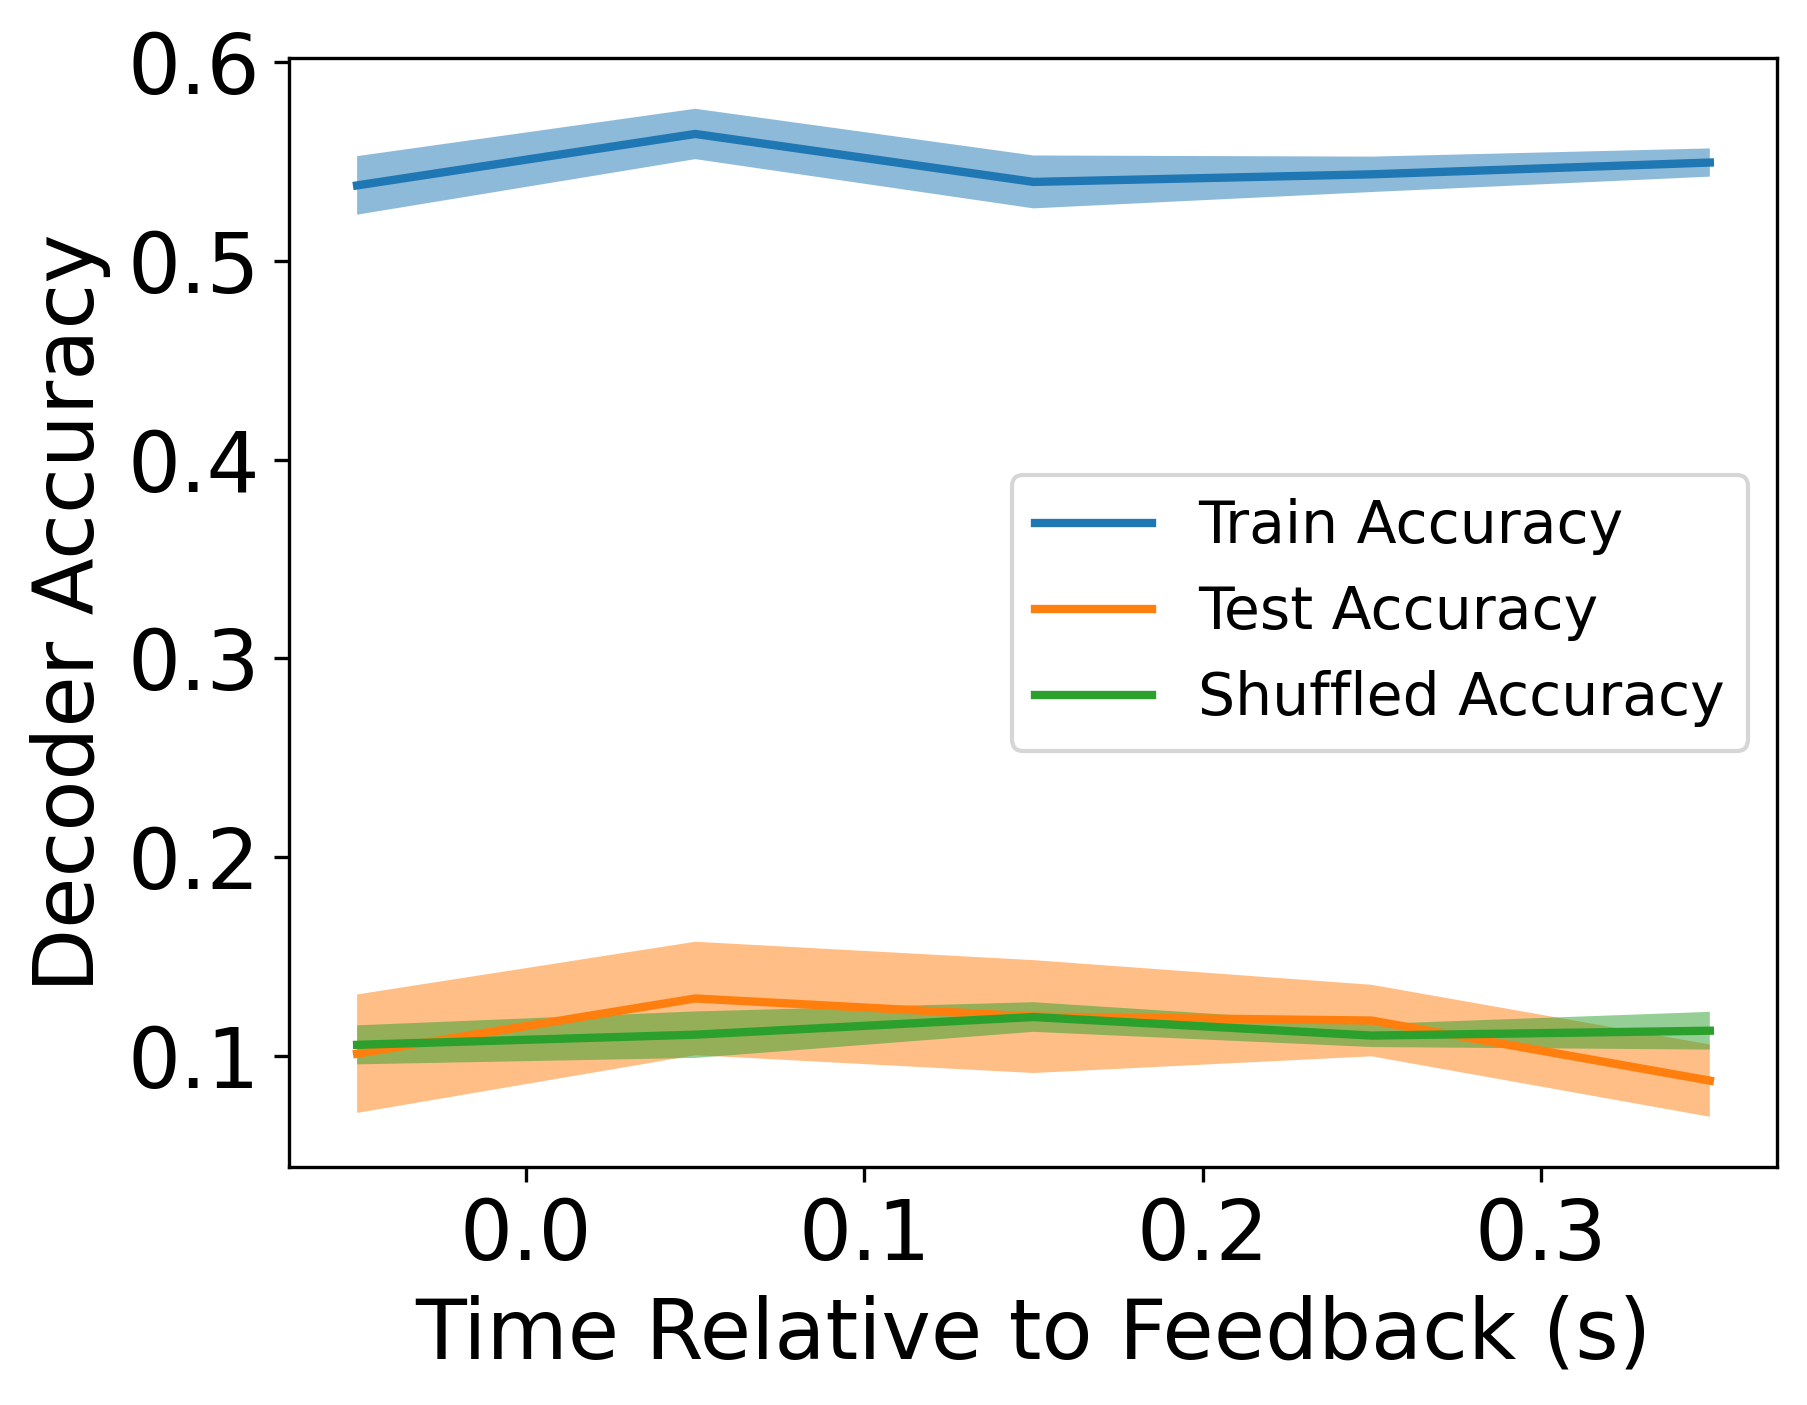

In [114]:
train_acc, test_acc, shuffled_acc, _, _ = io_utils.load_model_outputs(
    "test_pseudo_rule_decoding", 
    f"{pre_interval}_crossfixation_{post_interval}",
    "block_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    train_acc,
    0.15, 0.35, 0.1,
    ax,
    label="Train Accuracy",
    right_align=True, 
    # color='black'
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_acc,
    0.15, 0.35, 0.1,
    ax,
    label="Test Accuracy",
    right_align=True, 
    # color='black'
)

visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_acc,
    0.15, 0.35, 0.1,
    ax,
    label="Shuffled Accuracy",
    right_align=True, 
    # color='black'
)

# ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})

### Try Pseudo Population with Feedback decoding

In [115]:
splitter = ConditionTrialSplitter(valid_beh, "Response", 0.2)

In [116]:
frs = pd.read_pickle("/data/patrick_scratch/firing_rates_1300_FeedbackOnset_1500_100_bins.pickle")
frs = frs[frs.TrialNumber.isin(valid_beh.TrialNumber)]
frs = frs.astype({"TrialNumber": "int"})


In [117]:
frs.TimeBins.unique()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7])

In [118]:
pseudo_pop = pseudo_utils.generate_multi_split_pseudo_population(frs, splitter, 5, 1000, 100)

In [121]:
pseudo_frs = pseudo_pop[["UnitID", "TimeBins", "SpikeCounts", "PseudoTrialNumber"]].rename(
    columns={"PseudoTrialNumber": "TrialNumber", "SpikeCounts": "Value"}
)
labels = pseudo_pop[["PseudoTrialNumber", "Condition"]].rename(
    columns={"PseudoTrialNumber": "TrialNumber", "Condition": "Feature"}
).drop_duplicates()

In [ ]:
pre_interval = 1300
post_interval = 1500

splitter = DummyPseudoSplitter(pseudo_pop, 5)

classes = valid_beh.Response.unique()
init_params = {"n_inputs": 59, "p_dropout": 0.5, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.05, max_iter=100, batch_size=1000)
wrapped = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, pseudo_frs, labels, np.arange(0, 2.8, 0.1), splitter
)
io_utils.save_model_outputs(
    "test_pseudo_fb_decoding", 
    f"{pre_interval}_fb_{post_interval}",
    "trial_split",
    outputs
)

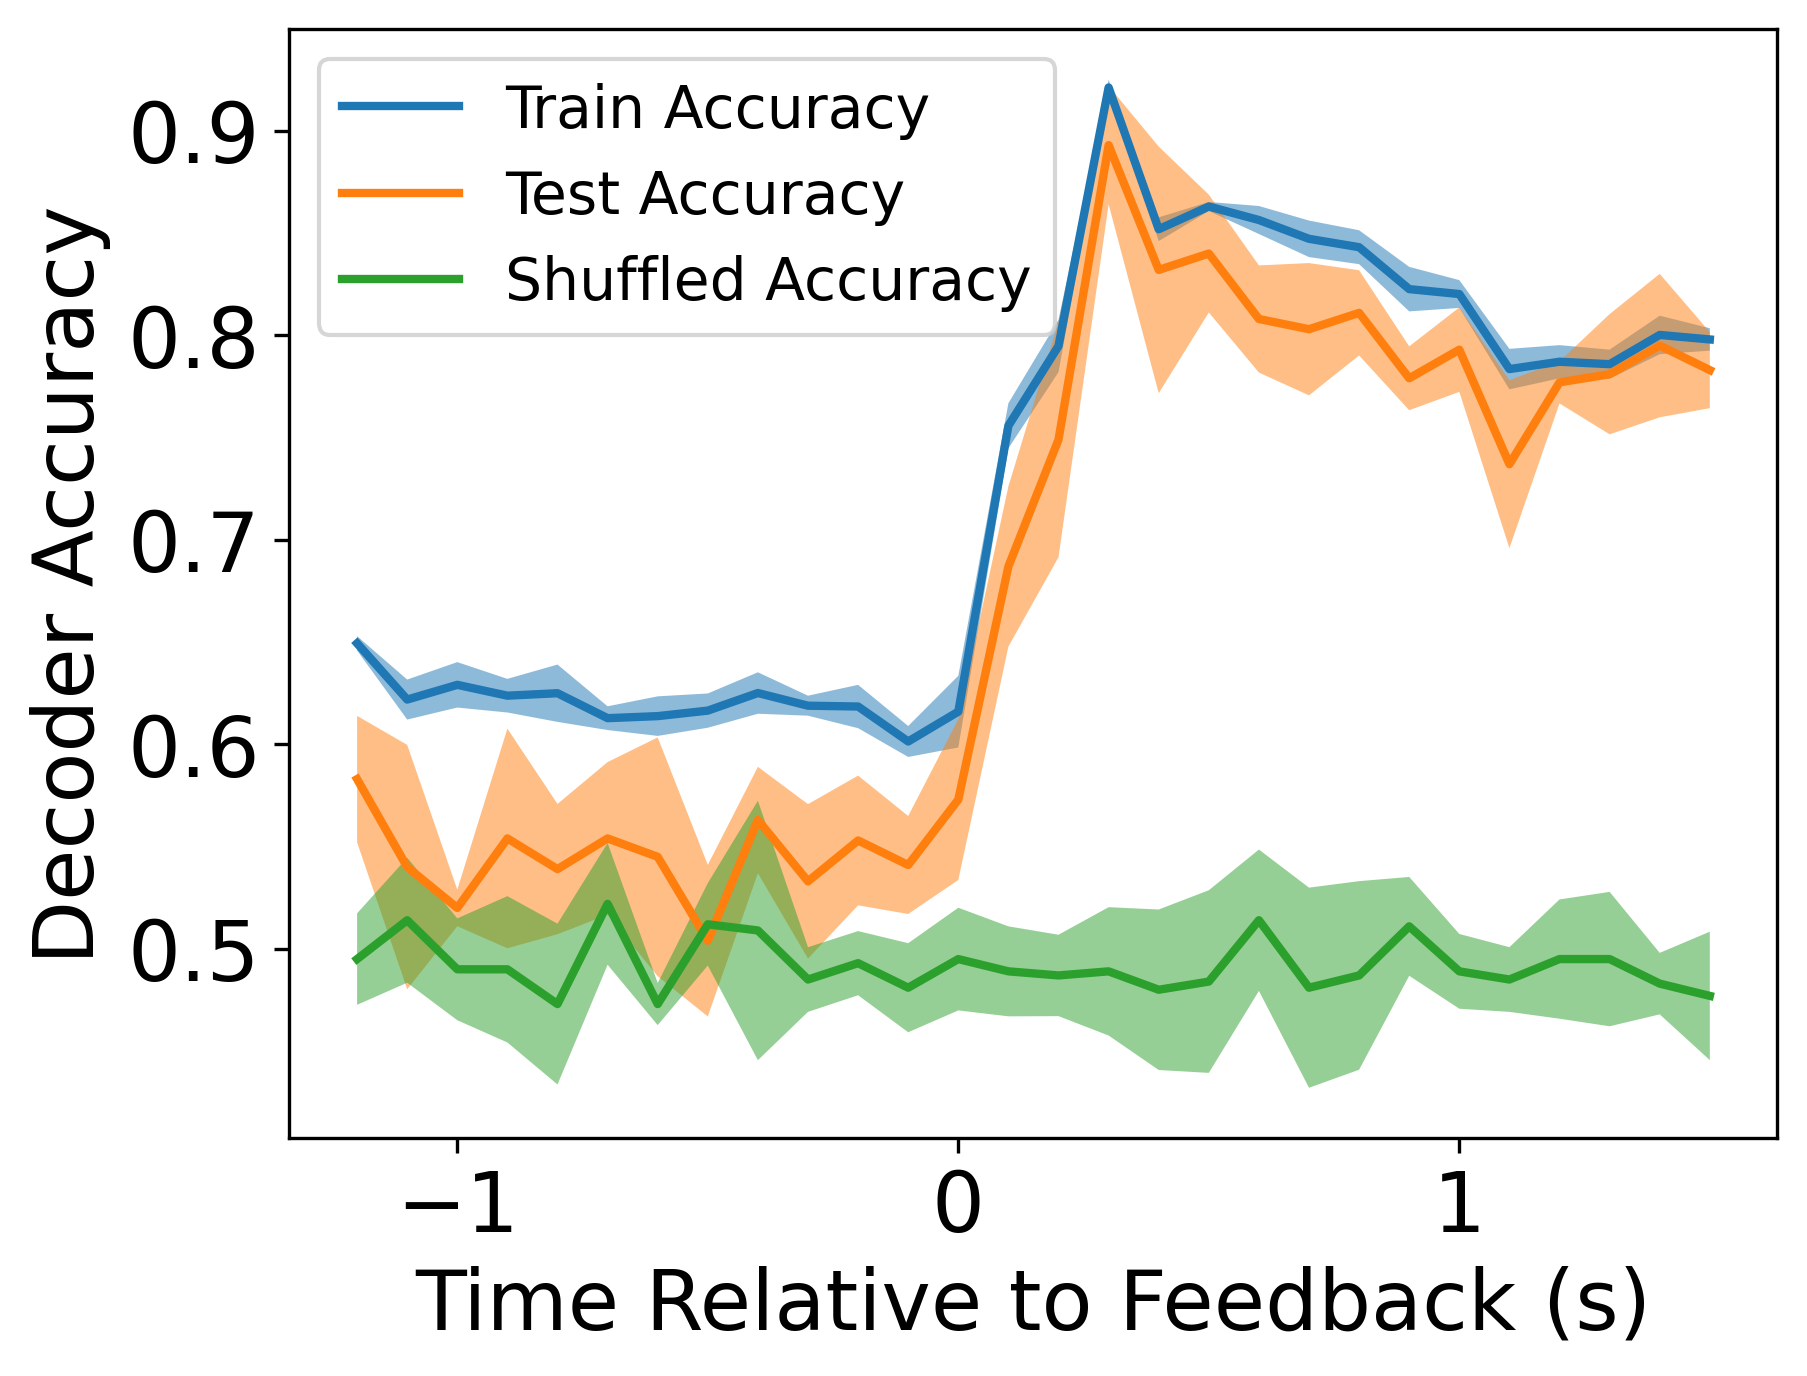

In [123]:
train_acc, test_acc, shuffled_acc, _, _ = io_utils.load_model_outputs(
    "test_pseudo_fb_decoding", 
    f"{pre_interval}_fb_{post_interval}",
    "trial_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    train_acc,
    1.3, 1.5, 0.1,
    ax,
    label="Train Accuracy",
    right_align=True, 
    # color='black'
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_acc,
    1.3, 1.5, 0.1,
    ax,
    label="Test Accuracy",
    right_align=True, 
    # color='black'
)

visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_acc,
    1.3, 1.5, 0.1,
    ax,
    label="Shuffled Accuracy",
    right_align=True, 
    # color='black'
)

# ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})